# TextRank statistics
Statistics for the data of how the sentences that the answers appear in rank (according to textrank applied to the paragraphs)

https://github.com/dailykirt/ML_Enron_email_summary/blob/master/notebooks/Text_rank_summarization.ipynb

Swedish bert model:
https://huggingface.co/KB/bert-base-swedish-cased

Alternative: https://huggingface.co/KBLab/sentence-bert-swedish-cased, with description: https://kb-labb.github.io/posts/2021-08-23-a-swedish-sentence-transformer/

https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2

Idea for creating embeddings for a sentence: https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958

good library for language features? https://spacy.io/usage/linguistic-features#vectors-similarity

In [4]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

# for sentence tokenization
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# for textrank:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [5]:
# load the data
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_train.head()

,choices,context,question,correct_answer,correct_answer_parsed,correct_answer_parsed_tok,correct_answer_parsed_stop,correct_answer_parsed_lemma,correct_answer_parsed_lemma_stop,correct_answer_loc,...,answer_location,sent_with_ans,answer_locations_text,paragraph_len,loc_frac,context_parsed,context_parsed_tok_lemma,context_parsed_tok_lemma_stop,context_parsed_tok_stop,context_parsed_tok
0,"[{'end': 224, 'extra': None, 'start': 175, 'te...",Visum för affärs- och konferensbesök\r\nOm du ...,Vad är ett visum?,ett tillstånd för att resa in och vara i ett land,ett tillstånd för att resa in och vara i ett land,"[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]",175,...,2,visum är ett tillstånd för att resa in och var...,[2],21,0.095238,"[visum för affärs- och konferensbesök, om du s...","[[visa, för, affär, och, konferensbesök], [om,...","[[visa, affär, konferensbesök], [om, skola, be...","[[visum, affärs-, konferensbesök], [om, ska, b...","[[visum, för, affärs-, och, konferensbesök], [..."
1,"[{'end': 707, 'extra': None, 'start': 681, 'te...",Eget företag\r\nEfter beslut\r\nBeslutet skick...,Vad ska du ta med när du hämtar ditt beslut?,ditt pass,ditt pass,"[ditt, pass]",[pass],"[du, pass]",[pass],156,...,2,när du ska hämta ditt beslut ska du ta med dit...,"[2, 3]",19,0.105263,"[eget företag, efter beslut beslutet skickas t...","[[egen, företag], [efter, beslut, beslut, skic...","[[egen, företag], [efter, beslut, beslut, skic...","[[eget, företag], [efter, beslut, beslutet, sk...","[[eget, företag], [efter, beslut, beslutet, sk..."
2,"[{'end': 1165, 'extra': None, 'start': 1154, '...",Utbytesdoktorander\r\nIntervju\r\nDu kommer at...,Hur länge gäller ett uppehållstillstånd för be...,ett år,ett år,"[ett, år]",[år],"[en, år]",[år],1619,...,18,så länge gäller tillståndet ett uppehållstills...,[18],25,0.720000,"[utbytesdoktorander intervju, du kommer att få...","[[utbytesdoktorand, intervju], [du, komma, att...","[[utbytesdoktorand, intervju], [du, komma, få,...","[[utbytesdoktorander, intervju], [du, kommer, ...","[[utbytesdoktorander, intervju], [du, kommer, ..."
3,"[{'end': 598, 'extra': None, 'start': 589, 'te...",Eget företag\r\nNär vi har tagit emot din ansö...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],589,...,8,kortet är ett bevis på att du har tillstånd at...,[8],21,0.380952,"[eget företag, när vi har tagit emot din ansök...","[[egen, företag], [när, vi, ha, ta, emot, du, ...","[[egen, företag], [när, ta, emot, ansökan], [o...","[[eget, företag], [när, tagit, emot, ansökan],...","[[eget, företag], [när, vi, har, tagit, emot, ..."
4,"[{'end': 1932, 'extra': None, 'start': 1924, '...",Flytta tillbaka till Sverige\r\nSå ansöker du\...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],673,...,8,kortet är ett bevis på att du har tillstånd at...,[8],21,0.380952,"[flytta tillbaka till sverige, så ansöker du d...","[[flytta, tillbaka, till, Sverige], [så, ansök...","[[flytta, tillbaka, Sverige], [så, ansöka, du,...","[[flytta, tillbaka, sverige], [så, ansöker, du...","[[flytta, tillbaka, till, sverige], [så, ansök..."


In [6]:

tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=True)
# model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')

In [12]:
def bert_tokenization(sentences_tokenized):
    # taking the original tokenized sentences and use the BERT tokenizer
    tok_sentences = []
    for sent in sentences_tokenized:
        context_sent = ' '.join(sent)
        # using BERT tokenizer
        tok_sent = tokenizer.tokenize(context_sent)
        clean_sent = ' '.join(tok_sent)
        tok_sentences.append(clean_sent)
    return tok_sentences

In [13]:
# function to rank sentences by textrank
# from https://github.com/dailykirt/ML_Enron_email_summary/blob/master/notebooks/Text_rank_summarization.ipynb
def rank_sentences(sentences, sentence_vectors):
    '''This function takes in a list of sentences to input into TextRank. The resulting ranks are what the model 
    calculated as the most important sentences. '''
    sim_mat = np.zeros([len(sentences), len(sentences)])
    #Initialize matrix with cosine similarity scores. 
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                shape_len = len(sentence_vectors[i])
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,shape_len), sentence_vectors[j].reshape(1,shape_len))[0,0]
    nx_graph = nx.from_numpy_array(sim_mat)
    
    #Pair sentence with it's similarity score then sort.    
    try:
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i],s[0], s[1]) for i,s in enumerate(sentences)), reverse=True)
    except:
        ranked_sentences = sorted(((0,s[0], s[1]) for i,s in enumerate(sentences)), reverse=True)

    return ranked_sentences

In [14]:
# tokenize the data
# https://huggingface.co/docs/transformers/quicktour
def encode_context_sentences(df, remove_stopwords=False):
    first_match = 0
    top_match = 0
    results_df = pd.DataFrame(columns=['answer', 'answer_loc', 'top_textrank_sent', 'top_textrank_loc', 'top_textrank_match', 'top_3_textrank_sents', 'top_3_textrank_loc', 'top_3_textrank_match', 'all_textrank_sents'])
    for index, row in df.iterrows():
        answer = row['correct_answer']
        loc = row['answer_location']
        
        context = row['context_parsed_tok']
        if remove_stopwords:
            context = row['context_parsed_tok_stop']

        tok_context = bert_tokenization(context)
        
        # Encode sentences using Sentence BERT
        embeddings = model.encode(tok_context)
        embeddings = np.array(embeddings)
    
        # run textrank on the embeddings
        # Make sentences tuple also containing ids to keep track of idx of sentences
        sent_tuples = [ (s, i) for i,s in enumerate(tok_context) ] # array of tuples (sentence, idx)
        ranked = rank_sentences(sent_tuples, embeddings)
        top_3_textrank_loc = [s[2] for s in ranked[:3] ]
        df_row = {'answer': answer, 'answer_loc': loc, 'top_textrank_sent': ranked[0], 'top_textrank_loc': ranked[0][2], 'top_textrank_match': False,
            'top_3_textrank_sents':ranked[:3], 'top_3_textrank_loc': top_3_textrank_loc , 'top_3_textrank_match': False, 'all_textrank_sents': ranked, 'sentence_tuples': sent_tuples, 'sentence_embeddings': embeddings}
        if loc == ranked[0][2]:
            first_match += 1
            df_row['top_textrank_match'] = True
        if  loc in top_3_textrank_loc:
            top_match += 1
            df_row['top_3_textrank_match'] = True

        results_df = results_df.append(df_row, ignore_index=True)
    
    return results_df, first_match, top_match

In [15]:
# run without removing stopwords
results_df_w_stopwords, first_match, top_match = encode_context_sentences(df_train) # Takes 55-60 min to run!
print('first: ', first_match)
print('top: ', top_match)

first:  33
top:  105


In [16]:
# Run with removing stopwords
results_df_no_stopwords, first_match, top_match = encode_context_sentences(df_train, True) # Takes 45 min to run!
print('first: ', first_match)
print('top: ', top_match)

first:  38
top:  140


In [17]:
# save textrank results to file
results_df_w_stopwords.to_pickle("./data_frames/textrank/df_textrank_traindata_results.pkl")
results_df_no_stopwords.to_pickle("./data_frames/textrank/df_textrank_traindata_stopwords_results.pkl")

# Instances where top text rank sentence match location: 33/962
# Instances where top 3 text rank sentence match location: 105/962

# Instances where top text rank sentence (with stopword removal) match location: 38/962
# Instances where top 3 text rank sentence (with stopword removal) match location: 140/962

In [18]:
# for each sentence, check at what location it appears in the TextRank ranking
results_df_no_stopwords_train = pd.read_pickle("./data_frames/textrank/df_textrank_traindata_stopwords_results.pkl")
results_df_w_stopwords_train = pd.read_pickle("./data_frames/textrank/df_textrank_traindata_results.pkl")


In [19]:
def find_textrank_rankings(df):
    textrank_locations = []
    for index, row in df.iterrows():
        rankings = row['all_textrank_sents'] # tuple (score, sentence, index)
        num_sents = len(rankings)
        ans_idx = row['answer_loc']
        for idx, sentence in enumerate(rankings):
            if sentence[2] == ans_idx:
                textrank_locations.append(idx/num_sents)
                break
    return textrank_locations

# create histogram of in which sentence the answer appear
def plot_textrank_stats(ranking, title, bins):
    mean = np.mean(ranking)
    plt.hist(ranking, density=True, bins=bins)
    plt.axvline(mean, color='g', linestyle='dashed', linewidth=1, label='mean: {:.2f}'.format(mean))
    plt.ylabel('Vol')
    plt.xlabel('Textrank ranking')
    plt.title(title)
    plt.legend()
    plt.show()

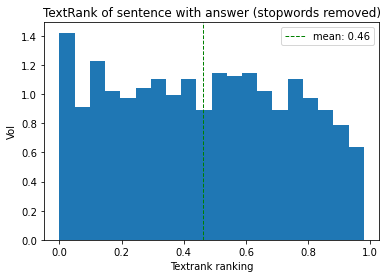

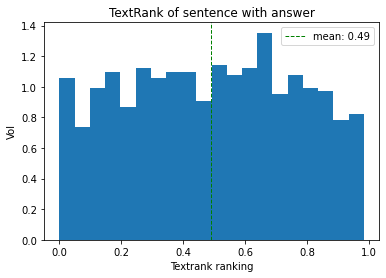

In [21]:
textrank_locations_no_stopwords_train = find_textrank_rankings(results_df_no_stopwords_train)
plot_textrank_stats(textrank_locations_no_stopwords_train, 'TextRank of sentence with answer (stopwords removed)', 20)
textrank_locations_w_stopwords_train = find_textrank_rankings(results_df_w_stopwords_train)
plot_textrank_stats(textrank_locations_w_stopwords_train, 'TextRank of sentence with answer', 20)